# Potato Disease Classification
Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

## Import all the Dependencies

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt


### Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3  # rgb
EPOCHS = 50

**Import data into tensorflow dataset object**

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)  # why shoing 68? cuz using batch so it wont overload

68

### Visualize some of the images from our dataset

(32, 256, 256, 3)
[0 0 1 1 1 0 1 0 0 2 0 1 0 0 1 1 0 0 0 1 1 1 0 0 1 2 1 0 1 0 0 0]


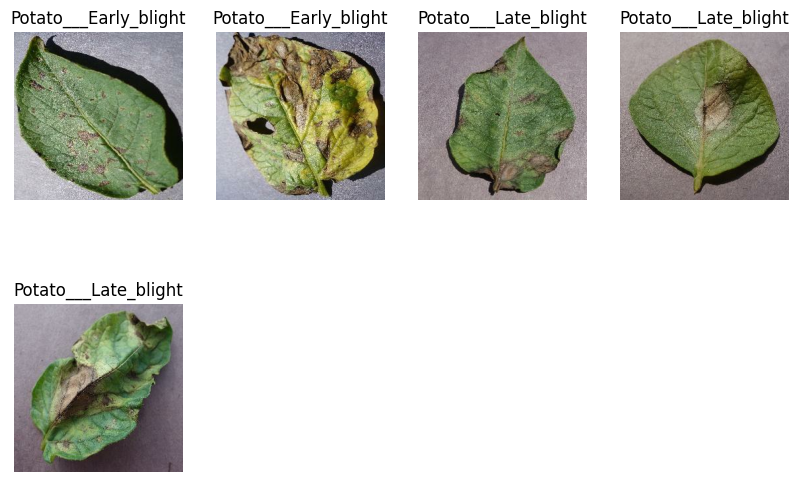

In [6]:
# lets see inside one batch
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())  # 0=>Early-blight, 1=> late blight
    # plt.imshow(image_batch[0].numpy().astype("uint8"))
    # plt.title(class_names[labels_batch[0]])
    plt.figure(figsize=(10, 10))

    for i in range(5):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
    plt.show()
    break

### Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [7]:
len(dataset)  # there are 68 batches
# 80% ==> training
# 20% ==> 10% validation, 10% test


68

In [8]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)
# like arr[:54]

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)
# like arr[54:]

14

In [11]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
# creating a function for split
def get_data_partitions_tf(
    ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000
):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [15]:
train_ds, val_ds, test_ds = get_data_partitions_tf(dataset)

In [16]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

### Cache, Shuffle, and Prefetch the Dataset

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model

**Creating a Layer for Resizing and Normalization**

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [18]:
from tensorflow.keras import models, layers  # so we dont need to type tf.keras

resize_and_rescale = tf.keras.Sequential(
    [
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.Rescaling(1.0 / 255),
    ]
)

**Data Augmentation**

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [19]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ]
)

**Applying Data Augmentation to Train Dataset**

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

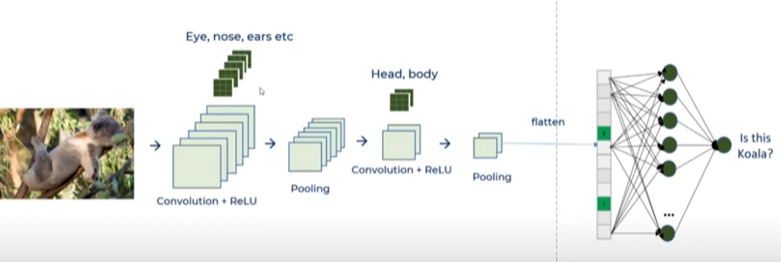

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential(
    [
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(n_classes, activation="softmax"),
    ]
)

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

**Compiling the Model**

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [22]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [23]:
history = model.fit(train_ds, epochs=EPOCHS, verbose=1, validation_data=val_ds)

Epoch 1/50


54/54 [==============================] - 30s 301ms/step - loss: 0.8600 - accuracy: 0.5069 - val_loss: 0.6616 - val_accuracy: 0.6979
Epoch 2/50
54/54 [==============================] - 11s 196ms/step - loss: 0.4798 - accuracy: 0.7946 - val_loss: 0.3203 - val_accuracy: 0.8646
Epoch 3/50
54/54 [==============================] - 9s 175ms/step - loss: 0.2951 - accuracy: 0.8854 - val_loss: 0.2620 - val_accuracy: 0.8802
Epoch 4/50
54/54 [==============================] - 9s 173ms/step - loss: 0.2364 - accuracy: 0.9045 - val_loss: 0.1647 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 9s 172ms/step - loss: 0.2031 - accuracy: 0.9253 - val_loss: 0.1856 - val_accuracy: 0.9323
Epoch 6/50
54/54 [==============================] - 9s 173ms/step - loss: 0.1820 - accuracy: 0.9288 - val_loss: 0.1631 - val_accuracy: 0.9583
Epoch 7/50
54/54 [==============================] - 9s 174ms/step - loss: 0.1505 - accuracy: 0.9421 - val_loss: 0.1244 - val_accuracy: 0.9688
Epoch 8/50
54/5

In [24]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 51ms/step - loss: 0.1801 - accuracy: 0.9375


In [25]:
scores

[0.1800733506679535, 0.9375]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [26]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [29]:
type(history.history["loss"])

list

In [30]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

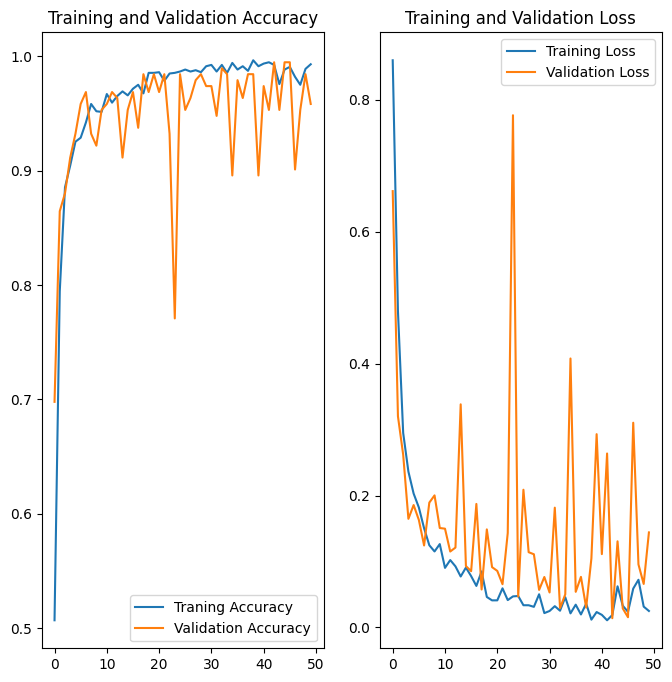

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label="Traning Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

### Run prediction on a sample image

first image to predict
first image's actual label:  Potato___Late_blight
1/1 [==============================] - 0s 59ms/step
predicted label: Potato___Late_blight


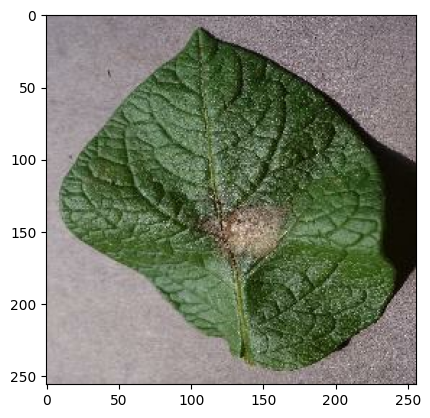

In [40]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label: ", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])


**Write a function for inference**

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

1/1 [==============================] - 0s 19ms/step


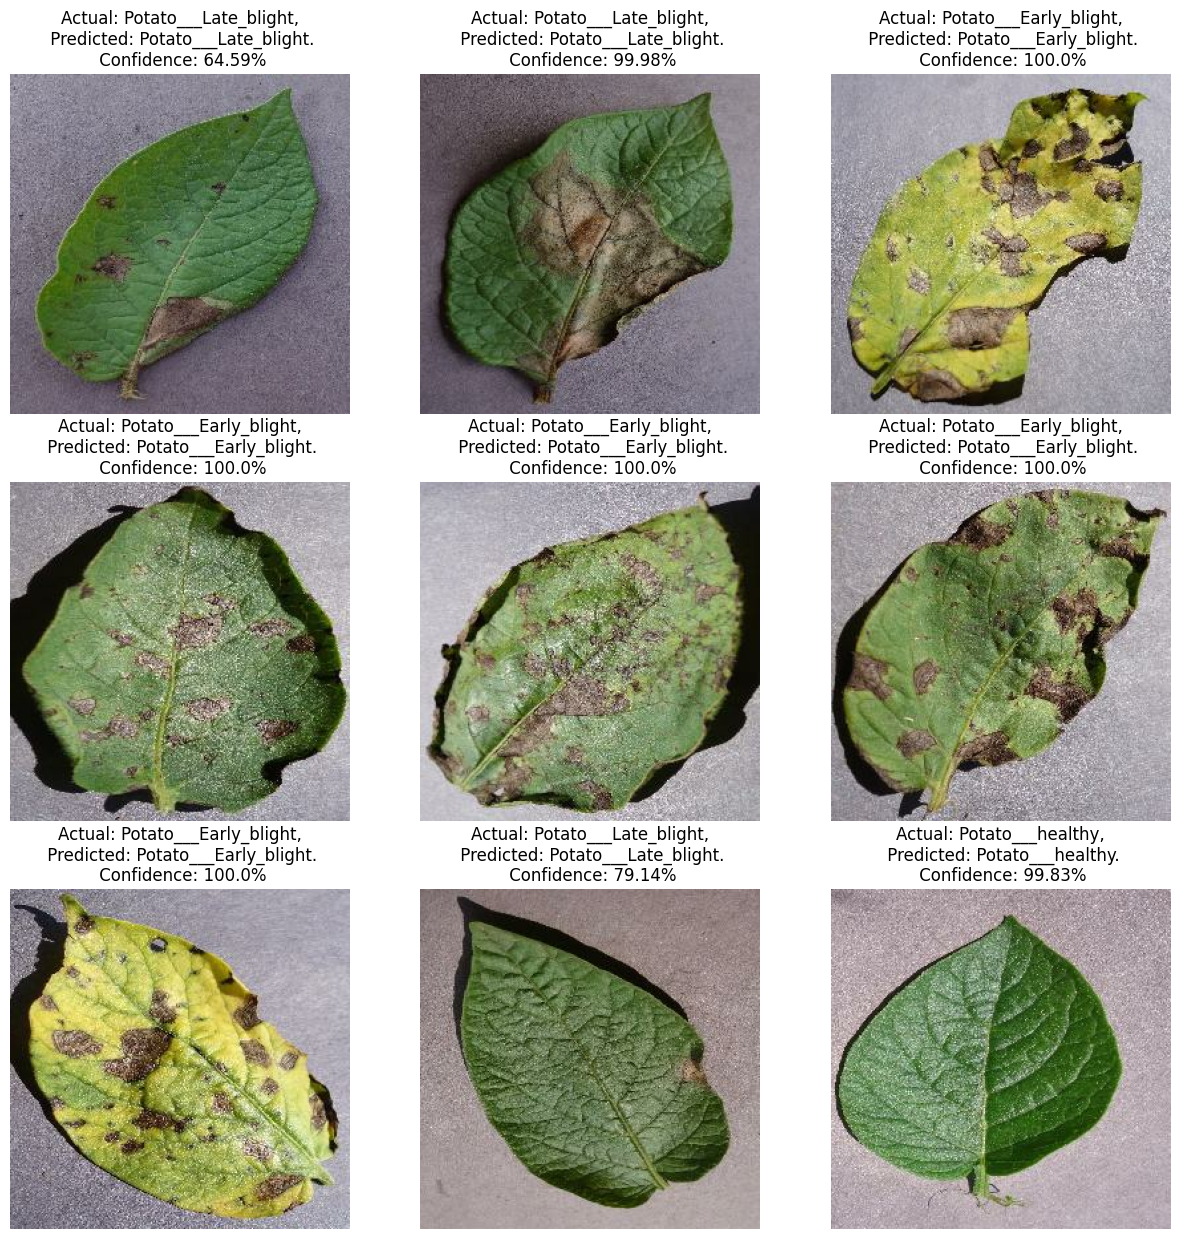

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Pass images[i].numpy() to the predict function
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]

        plt.title(
            f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%"
        )
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [47]:
import os

os.listdir("../models")
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")


INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [44]:
# model_version = 1
# model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
